In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
data = pd.read_csv('NVDA.csv', header=0, usecols=['Date', 'Close'], parse_dates=True, index_col='Date')
print(data)

                 Close
Date                  
2015-08-26   21.809999
2015-08-27   22.629999
2015-08-28   22.730000
2015-08-31   22.480000
2015-09-01   21.559999
...                ...
2020-08-19  485.540009
2020-08-20  485.640015
2020-08-21  507.339996
2020-08-24  508.809998
2020-08-25  510.000000

[1259 rows x 1 columns]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


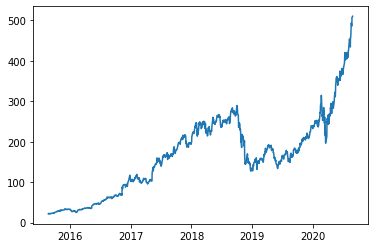

In [3]:
plt.plot(data['Close'])
plt.show()

In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data)

[[5.11833592e-04]
 [2.19064777e-03]
 [2.39538326e-03]
 ...
 [9.94554082e-01]
 [9.97563668e-01]
 [1.00000000e+00]]


In [5]:
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [6]:
def create_dataset(dataset, timestep=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep - 1):
        data_x.append(dataset[i:(i+timestep),0])
        data_y.append(dataset[i+timestep,0])
    return np.array(data_x), np.array(data_y)

In [7]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

print(train_x)

[[5.11833592e-04]
 [2.19064777e-03]
 [2.39538326e-03]
 [1.88354966e-03]
 [0.00000000e+00]
 [1.33076734e-03]
 [1.45360945e-03]
 [3.88995577e-04]
 [2.29301654e-03]
 [1.37171607e-03]
 [2.08828310e-03]
 [2.23159651e-03]
 [2.31349193e-03]
 [2.82532552e-03]
 [3.15289697e-03]
 [3.58283514e-03]
 [3.54189255e-03]
 [4.03325280e-03]
 [2.72295471e-03]
 [2.94816354e-03]
 [3.84899270e-03]
 [4.19703955e-03]
 [3.56236180e-03]
 [4.40176889e-03]
 [6.32626524e-03]
 [5.34354474e-03]
 [6.63336335e-03]
 [7.90271270e-03]
 [8.57833304e-03]
 [9.13111332e-03]
 [9.43821348e-03]
 [9.23348004e-03]
 [9.80673366e-03]
 [9.90910038e-03]
 [1.18745434e-02]
 [1.20178548e-02]
 [1.28982106e-02]
 [1.27958398e-02]
 [1.27139485e-02]
 [1.19769081e-02]
 [1.40037691e-02]
 [1.43927626e-02]
 [1.41266071e-02]
 [1.40856645e-02]
 [1.45565494e-02]
 [1.25296884e-02]
 [1.39423511e-02]
 [1.46179715e-02]
 [1.42085026e-02]
 [1.32462574e-02]
 [1.25911064e-02]
 [2.04528703e-02]
 [2.01662456e-02]
 [1.89378429e-02]
 [1.83236446e-02]
 [1.809843

In [8]:
print(train_x.shape)

(879, 1)


In [9]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

print(train_x)

[[[5.11833592e-04]]

 [[2.19064777e-03]]

 [[2.39538326e-03]]

 [[1.88354966e-03]]

 [[0.00000000e+00]]

 [[1.33076734e-03]]

 [[1.45360945e-03]]

 [[3.88995577e-04]]

 [[2.29301654e-03]]

 [[1.37171607e-03]]

 [[2.08828310e-03]]

 [[2.23159651e-03]]

 [[2.31349193e-03]]

 [[2.82532552e-03]]

 [[3.15289697e-03]]

 [[3.58283514e-03]]

 [[3.54189255e-03]]

 [[4.03325280e-03]]

 [[2.72295471e-03]]

 [[2.94816354e-03]]

 [[3.84899270e-03]]

 [[4.19703955e-03]]

 [[3.56236180e-03]]

 [[4.40176889e-03]]

 [[6.32626524e-03]]

 [[5.34354474e-03]]

 [[6.63336335e-03]]

 [[7.90271270e-03]]

 [[8.57833304e-03]]

 [[9.13111332e-03]]

 [[9.43821348e-03]]

 [[9.23348004e-03]]

 [[9.80673366e-03]]

 [[9.90910038e-03]]

 [[1.18745434e-02]]

 [[1.20178548e-02]]

 [[1.28982106e-02]]

 [[1.27958398e-02]]

 [[1.27139485e-02]]

 [[1.19769081e-02]]

 [[1.40037691e-02]]

 [[1.43927626e-02]]

 [[1.41266071e-02]]

 [[1.40856645e-02]]

 [[1.45565494e-02]]

 [[1.25296884e-02]]

 [[1.39423511e-02]]

 [[1.46179715

In [10]:
model = Sequential()
model.add(LSTM(256, input_shape=(1,1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
model.fit(train_x, train_y, epochs=1, batch_size=1, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

879/879 [==============================] - 2s 2ms/step - loss: 0.0184 - accuracy: 0.0011
Keras model loss =  0.0011785334208980203
Keras model accuracy =  0.0011376563925296068


In [12]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

print(train_predictions)

[[0.07078817]
 [0.07138625]
 [0.0714595 ]
 [0.07127658]
 [0.0706068 ]
 [0.07107934]
 [0.07112312]
 [0.07074463]
 [0.0714229 ]
 [0.07109398]
 [0.07134971]
 [0.07140088]
 [0.07143024]
 [0.07161361]
 [0.07173115]
 [0.07188565]
 [0.07187092]
 [0.07204792]
 [0.07157683]
 [0.07165763]
 [0.07198152]
 [0.07210702]
 [0.07187831]
 [0.0721809 ]
 [0.07287899]
 [0.07252175]
 [0.07299101]
 [0.07345536]
 [0.07370362]
 [0.07390732]
 [0.07402074]
 [0.07394505]
 [0.07415688]
 [0.07419485]
 [0.0749256 ]
 [0.07497916]
 [0.07530877]
 [0.07527041]
 [0.07523969]
 [0.07496387]
 [0.07572457]
 [0.07587141]
 [0.07577091]
 [0.07575545]
 [0.07593319]
 [0.07517064]
 [0.07570139]
 [0.07595652]
 [0.07580182]
 [0.07543948]
 [0.07519361]
 [0.0781911 ]
 [0.07808   ]
 [0.07760528]
 [0.07736892]
 [0.07728243]
 [0.07681209]
 [0.07728243]
 [0.07728243]
 [0.07777905]
 [0.07785025]
 [0.07806408]
 [0.07769212]
 [0.0778898 ]
 [0.07785812]
 [0.07806408]
 [0.0783262 ]
 [0.07914934]
 [0.07894877]
 [0.07889274]
 [0.07995582]
 [0.07

In [13]:
train_predictions = scaler.inverse_transform(train_predictions)
train_y = scaler.inverse_transform([train_y])

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

print(train_predictions)

[[ 56.135773]
 [ 56.4279  ]
 [ 56.463676]
 [ 56.37433 ]
 [ 56.047184]
 [ 56.277992]
 [ 56.299377]
 [ 56.114506]
 [ 56.4458  ]
 [ 56.28514 ]
 [ 56.41005 ]
 [ 56.435043]
 [ 56.449383]
 [ 56.538948]
 [ 56.596363]
 [ 56.67182 ]
 [ 56.66463 ]
 [ 56.751083]
 [ 56.52099 ]
 [ 56.56045 ]
 [ 56.71865 ]
 [ 56.77995 ]
 [ 56.668243]
 [ 56.816036]
 [ 57.15701 ]
 [ 56.98252 ]
 [ 57.211727]
 [ 57.438538]
 [ 57.55979 ]
 [ 57.659286]
 [ 57.71469 ]
 [ 57.677715]
 [ 57.781185]
 [ 57.79973 ]
 [ 58.15666 ]
 [ 58.182816]
 [ 58.343815]
 [ 58.32508 ]
 [ 58.31007 ]
 [ 58.17535 ]
 [ 58.54691 ]
 [ 58.61863 ]
 [ 58.569542]
 [ 58.56199 ]
 [ 58.648804]
 [ 58.276344]
 [ 58.535583]
 [ 58.660202]
 [ 58.58464 ]
 [ 58.407658]
 [ 58.287567]
 [ 59.75166 ]
 [ 59.69739 ]
 [ 59.46552 ]
 [ 59.35007 ]
 [ 59.307827]
 [ 59.078094]
 [ 59.307827]
 [ 59.307827]
 [ 59.5504  ]
 [ 59.585175]
 [ 59.68962 ]
 [ 59.50794 ]
 [ 59.604492]
 [ 59.58902 ]
 [ 59.68962 ]
 [ 59.817646]
 [ 60.2197  ]
 [ 60.121735]
 [ 60.094368]
 [ 60.613617]
 [ 60.

In [14]:
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:,:] = np.nan
train_predict_plot[1:len(train_predictions)+1, :] = train_predictions

In [15]:
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:,:] = np.nan
test_predict_plot[
    len(train_predictions)+2+1:len(scaled_data)-1, :] = test_predictions

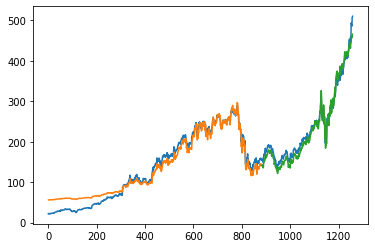

In [16]:
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()